In [1]:
## 기본
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
import random
import time
import itertools

from quant_functions import anal_funcs, data_funcs

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
## plt.style.use("fivethirtyeight")
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = (10,6)

In [50]:
## kapital: 자기자본
## prop: 부동산투자금액
## leverage: 부채비율(주담대)
## debt: 차입금액 == prop*leverage
## stock: 주식투자금액 == kapital - prop*(1-leverage)

## propReturn: 부동산수익금액
## stockReturn: 주식수익금액
## debtCost: 차입비용
## totalReturn: 총수익금액 == propReturn + stockReturn - debtCost

## stockExpYield: 주식기대수익률; S&P500지수 기준 9.6% NASDAQ지수 기준 13.2% (2004~2023)
## propExpYield: 부동산기대수익률; KB주택가격지수 기준 6.7% (2004~2023)
## debtCostRate: 차입금리; 3.5% (2004~2023)

## 가정1: 부동산은 leverage만큼 차입하고, 주식은 차입하지 않는다.
## 가정2: 부동산투자금액을 제외한 자기자본은 주식에 투자한다.
## 가정3: 부동산, 주식 모두 역사적 기대수익률을 따르며 시세예측은 불가능하다.

In [51]:
def calTotalReturn(kapital, prop, leverage, propExpYield, stockExpYield, debtCostRate):
    debt = prop*leverage
    stock = kapital - prop*(1-leverage)
    propReturn = prop*propExpYield
    stockReturn = stock*stockExpYield
    debtCost = debt*debtCostRate
    totalReturn = propReturn + stockReturn - debtCost
    return totalReturn

Text(0, 0.5, '총수익금액')

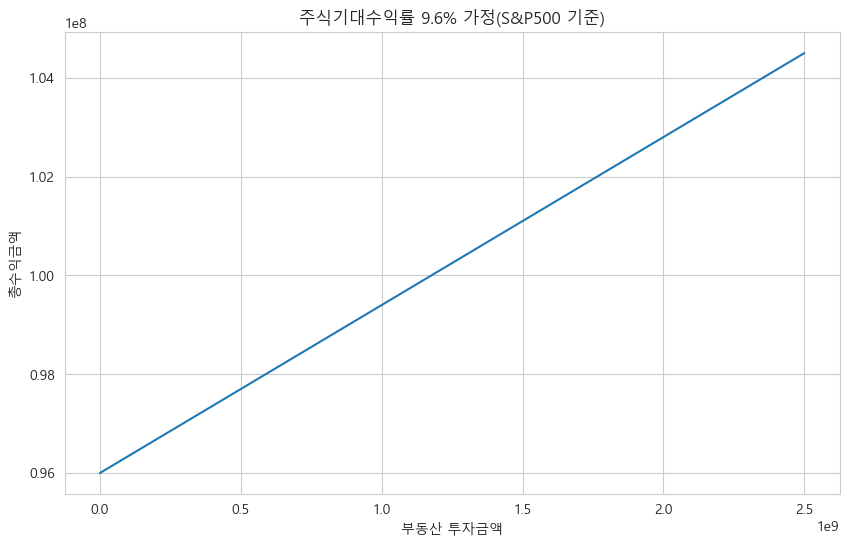

In [59]:
## 주택투자금액이 0~최대투자금액까지 변화할 때 총수익금액의 변화 시뮬레이션; 주식기대수익률 9.6% 가정(S&P500 기준)
kapital = 10*1e8
leverage = 0.6
propExpYield = 0.067
stockExpYield = 0.096
debtCostRate = 0.042

maxProp = kapital/0.4 ## 최대 부동산 투자금액 초과시 주식투자금액이 음수가 되므로 제한
prop = np.linspace(0, maxProp, 100)
totalReturn = calTotalReturn(kapital, prop, leverage, propExpYield, stockExpYield, debtCostRate)
plt.plot(prop, totalReturn)
plt.title('주식기대수익률 9.6% 가정(S&P500 기준)')
plt.xlabel('부동산 투자금액')
plt.ylabel('총수익금액')

Text(0, 0.5, '총수익금액')

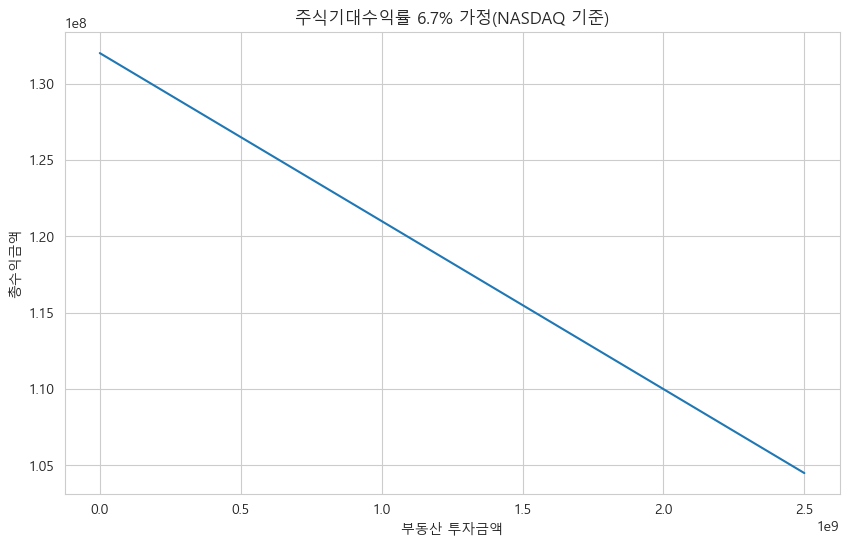

In [60]:
## 주택투자금액이 0~최대투자금액까지 변화할 때 총수익금액의 변화 시뮬레이션; 주식기대수익률 6.7% 가정(NASDAQ 기준)
kapital = 10*1e8
leverage = 0.6
propExpYield = 0.067
stockExpYield = 0.132
debtCostRate = 0.042

maxProp = kapital/0.4
prop = np.linspace(0, maxProp, 100)
totalReturn = calTotalReturn(kapital, prop, leverage, propExpYield, stockExpYield, debtCostRate)
plt.plot(prop, totalReturn)
plt.title('주식기대수익률 6.7% 가정(NASDAQ 기준)')
plt.xlabel('부동산 투자금액')
plt.ylabel('총수익금액')

In [61]:
# 다음과 같이 식을 정리하면
# totalReturn = propReturn + stockReturn - debtCost
# totalReturn = prop*propExpYield + stock*stockExpYield - debt*debtCostRate
# totalReturn = prop*propExpYield + (kapital - prop*(1-leverage))*stockExpYield - prop*leverage*debtCostRate
# totalReturn = kapital*stockExpYield + prop*(propExpYield -(1-leverage)*stockExpYield - leverage*debtCostRate)
# totalReturn = Alpha + Beta*prop

# Beta가 0일 때 무차별 지점이 발생함
# Beta == (propExpYield -(1-leverage)*stockExpYield - leverage*debtCostRate) = 0
# 즉, propExpYield = (1-leverage)*stockExpYield + leverage*debtCostRate 일 때 무차별 지점 발생

Text(0, 0.5, '총수익금액')

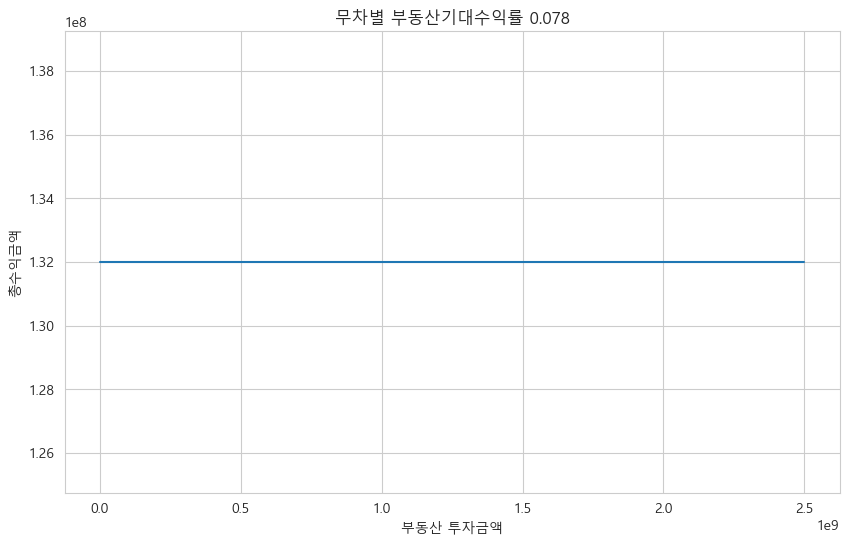

In [93]:
## prop 최적화
kapital = 10*1e8
leverage = 0.6
stockExpYield = 0.132
debtCostRate = 0.042
propExpYield = (1-leverage)*stockExpYield + leverage*debtCostRate

maxProp = kapital/0.4
prop = np.linspace(0, maxProp, 100)
totalReturn = calTotalReturn(kapital, prop, leverage, propExpYield, stockExpYield, debtCostRate)
plt.plot(prop, totalReturn)
plt.title(f'무차별 부동산기대수익률 {propExpYield:.3f}')
plt.xlabel('부동산 투자금액')
plt.ylabel('총수익금액')

In [89]:
## property 요구수익률
def calMinPropExpYield(stockExpYield=0.132, leverage=0.6, debtCostRate=0.042):
    return (1-leverage)*stockExpYield + leverage*debtCostRate
calMinPropExpYield()

0.07800000000000001

In [90]:
## stock 요구수익률
def calMinStockExpYield(propExpYield=0.067, leverage=0.6, debtCostRate=0.042):
    return (propExpYield-leverage*debtCostRate)/(1-leverage)
calMinStockExpYield()

0.10450000000000001

In [91]:
## debt 최대허용금리
def calMaxDebtCostRate(propExpYield=0.067, stockExpYield=0.132, leverage=0.6):
    return (propExpYield - (1-leverage)*stockExpYield)/leverage
calMaxDebtCostRate()

0.023666666666666662

In [82]:
## property 최소 레버리지
def calMinLeverage(stockExpYield, propExpYield, debtCostRate):
    return (stockExpYield-propExpYield)/(stockExpYield-debtCostRate)
calMinLeverage(stockExpYield=0.132, propExpYield=0.062, debtCostRate=0.04)

0.7608695652173914